#### /!\ Notice (read me before !)

Before running the following repo, you need to run :

1. `/fetch_logs.ipynb` : parse & clean logs
2. `/agregate_logs.ipynb` : aggregate logs

`most_visited_datasets.ipnyb` is optional cause it doesn't change so much over time. (last run : 10/01/18)




# "Voir aussi" feature implementation

The purpose of this notebook is to find similarity between dataset in order to build recommendation.

More datasets are visited together in a same session, closer they are from each other.

We checked both session & API.

In [1]:
import json
from collections import defaultdict, Counter
import pickle
import glob
import os
import itertools
import editdistance # Levenshtein distance

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from src import utils
from IPython.display import clear_output

# Parse actions to dataset ids

First, we need to group visited URL by type. For instance, we want to group .fr/.en/.es for the same actions.

By action, we mean "search, posts, actions, goal, ..".

In [2]:
source_dir = '../deduplicated_logs'
target_dir = '../parsed_logs'

filenames = glob.glob(source_dir + '/*')

## Compute monthly filename.json (e.g. : 2017-12-26)
# a_month_ago = pd.datetime.today() + pd.DateOffset(months=-1)
# date_range = pd.date_range(a_month_ago, pd.datetime.today()).strftime('%Y-%m-%d')
# monthly_files = ['deduplicated_logs/' + date + '.json' for date in date_range]

monthly_files = np.sort(filenames)[::-1][:31]
print("today's date: %s\nparsing json from %s to %s" % (
    pd.datetime.today().strftime('%Y-%m-%d'), monthly_files[-1].split('/')[2][:-5], monthly_files[0].split('/')[2][:-5]) )
unhandled_actions = []
visits_parsed = []
for filename in monthly_files:
    with open(filename, 'r') as f:
        visits = json.load(f)
    visits_parsed_file, unhandled_actions_file = utils.parse_visits(visits)
    visits_parsed += visits_parsed_file
    unhandled_actions += unhandled_actions_file
    with open(os.path.join(target_dir, os.path.basename(filename)), 'w') as f:
        json.dump(visits_parsed_file, f)
with open(os.path.join(target_dir, os.path.basename('all_visits_parsed_file')), 'w') as f:
    json.dump(visits_parsed, f)

today's date: 2018-01-10
parsing json from 2017-12-11 to 2018-01-10


In [3]:
len(visits_parsed)

264275

In [4]:
len(unhandled_actions)

203719

`unhandled_actions` contains mainly "territoires", "avatar" and odd URL. Majority of the datasets were correctly parsed so let's keep going.

`visits_parsed` is a list of list of tuples : `[[(a, b), (a,c)], [(c,d)], [(a,c)], ...]`

each tuple is a (type, name) were `type` can be: `id` (=API community), `keyword` (=keyword search), `slug_or_id` (dataset_API or dataset) and name is the value (e.g. a dataset name).

API Community eg : https://www.data.gouv.fr/api/1/datasets/community_resources/?sort=-created_at&page_size=10&dataset=58e53811c751df03df38f42d&lang=fr&_=1512404531050

-> "58e53811c751df03df38f42d" correspond au RNA, mais quel diff avec api ?


We will focus our study on `slug_or_id`.

In [5]:
# Dict session_num -> list_of_action_tuple
visits_parsed_as_dict = dict(zip(range(0,len(visits_parsed)), visits_parsed))
visits_parsed_as_dict[2]

[('slug_or_id', 'centres-des-impots-fonciers-par-commune-en-bretagne')]

### First, let's replace dataset-id by their name (or slug) in order. All of them are supposedly unique so no problem.

To do so, we first need to import the list of all datasets (datasets.csv) il order to get the mapping.

In [6]:
datasets_ref = pd.read_csv('../list_of_all_datasets_dgfr/datasets-2017-12-13-18-23.csv', sep=';')
# Mapping id -> slug
datasets_slug_id = datasets_ref.set_index('slug')['id'].to_dict()
# Mapping id -> slug (will be used for readability)
datasets_id_slug = datasets_ref.set_index('id')['slug'].to_dict()

In [7]:
datasets_ref.groupby('id')['slug'].count().value_counts()

1    32077
Name: slug, dtype: int64

Chaque `id` possède un unique `slug`. 

Pas très pratique étant donné que certain slug sont obsolètes (ont été changés) : **comment récupérer les nouveaux id des anciens slugs ?** 


On verra plus tard.

In [8]:
# Dict session_num -> set() of visited datasets (by API or through web)
session_datasets = {}
slug_not_found = []
for key, value in visits_parsed_as_dict.items():
    if len(value) > 0:
        # (optional) : slug not found in dict datasets_ref
        slug_not_found += set(tup[1] for tup in value if (tup[0] == "slug_or_id") & ((tup[1] not in datasets_slug_id) & (tup[1] not in datasets_id_slug.keys())))
        # convert slug to id & build unique list
        unique_list = set(datasets_slug_id.get(tup[1], tup[1]) for tup in value if tup[0] == "slug_or_id")
        if len(unique_list) > 1 : # list of at least 2 different datasets
            session_datasets[key] = unique_list
    else:
        pass # We don't care about empty session

In [9]:
len(slug_not_found)

9708

In [10]:
slug_not_found[:10]

['statistiques-nombre-de-pratiquant-de-skateboard',
 'nombre-de-deces-3',
 'plan-cadastral-informatise-pci',
 'horaires-des-lignes-transilien',
 'statistiques-nombre-de-pratiquant-de-skateboard',
 'reserves-naturelles-regionales-rnr-en-bourgogne',
 'zones-vulnerables-aux-nitrates-2012',
 'stations-de-traitement-des-eaux-usees-onm',
 'plan-cadastral-informatise-pci',
 'plan-cadastral-informatise-pci']

In [11]:
datasets_slug_id.get('contrats-de-milieu-guadeloupe-onm', 'key not found :(')

'key not found :('

When looking inside session_datasets, we observe that ~9K slug were not found in the dict `datasets_slug_id`.

They are stored in `slug_not_found` so someone can have a look.

Some of them are definitely working links, some other are 404's.


**We ignore them for now, but it could be interesting to have a closer look into them**

In [12]:
len(session_datasets)

27042

### Now that we have a dict of set of datasets, let's count how many pairwise datasets appears together.

For example

In [13]:
# Two lists
L1 = ['a', 'b', 'c', 'd'] 
L2 =  ['b', 'a', 'c'] 
# We want : (a, b): 2 (a, c): 2 (b, c): 2, (b, d): 1 (c, d):1

# Compute combination (we need to sort beforehand !)
L1_comb = list(itertools.combinations(np.sort(L1), 2)) # (ab) (ac) (ad) (bc) (bd) (cd)
L2_comb = list(itertools.combinations(np.sort(L2), 2)) # (ba) (bc) (ac)

# Counter tuple
c1 = Counter(L1_comb)
print('L1=  %s' % c1)
c2 = Counter(L2_comb)
print('Somme= %s' % (c1 + c2))

L1=  Counter({('a', 'b'): 1, ('a', 'c'): 1, ('a', 'd'): 1, ('b', 'c'): 1, ('b', 'd'): 1, ('c', 'd'): 1})
Somme= Counter({('a', 'b'): 2, ('a', 'c'): 2, ('b', 'c'): 2, ('a', 'd'): 1, ('b', 'd'): 1, ('c', 'd'): 1})


In [14]:
# Could be optimize. Caution : ~10min.
pairwise_count = Counter()
c = 0
for key, val in session_datasets.items():
    val_as_list = np.sort(list(val))
    val_combinations = list(itertools.combinations(val_as_list, 2))
    pairwise_count += Counter(val_combinations)
    c += 1
    clear_output(wait=True)
    print('%s/%s' % (c, len(session_datasets.items())))

27042/27042


In [15]:
pairwise_count.most_common(5)

[(('58e5924b88ee3802ca255566', '59b0020ec751df07d5f13bcf'), 1074),
 (('55f6a4d7c751df136147eab3', '57d6ded9c751df275ab8181a'), 459),
 (('536991c5a3a729239d203d4b', '545b55e1c751df52de9b6045'), 398),
 (('5369995ba3a729239d205221', '545b55e1c751df52de9b6045'), 278),
 (('53ca2be2a3a7294a1ddd7847', '58e53811c751df03df38f42d'), 277)]

In [16]:
paired_df = pd.DataFrame(list(pairwise_count.items()), columns=['paired_datasets', 'co_occurence'])
paired_df.sort_values('co_occurence', ascending=False, inplace=True)
paired_df.head()

,paired_datasets,co_occurence
870,"(58e5924b88ee3802ca255566, 59b0020ec751df07d5f...",1074
624,"(55f6a4d7c751df136147eab3, 57d6ded9c751df275ab...",459
630,"(536991c5a3a729239d203d4b, 545b55e1c751df52de9...",398
1396,"(5369995ba3a729239d205221, 545b55e1c751df52de9...",278
26,"(53ca2be2a3a7294a1ddd7847, 58e53811c751df03df3...",277


### Now it could be interesting to have : for each datasets, all _twins_ ordered by co-occurence

In [17]:
paired_df[['dataset_1', 'dataset_2']] = paired_df.paired_datasets.apply(pd.Series)
paired_df = paired_df.loc[:, ['dataset_1', 'dataset_2','co_occurence']]
# Only co-occurence > 1
paired_df = paired_df.loc[paired_df.co_occurence > 1]

In [18]:
paired_df.head(2)

,dataset_1,dataset_2,co_occurence
870,58e5924b88ee3802ca255566,59b0020ec751df07d5f13bcf,1074
624,55f6a4d7c751df136147eab3,57d6ded9c751df275ab8181a,459


In [19]:
# Let's build a dict : dataset_A -> (dataset_E : 200), (dataset_B : 130), ...

paired_df_grouped = paired_df.groupby('dataset_1')['dataset_2', 'co_occurence'].agg(lambda x: list(x))
paired_df_grouped.reset_index(inplace=True)
paired_df_grouped['all_co_occurence'] = paired_df_grouped.apply(lambda x: tuple(zip(x.dataset_2, x.co_occurence)), axis=1)
paired_df_grouped.head(2)

,dataset_1,dataset_2,co_occurence,all_co_occurence
0,53698e0ea3a729239d20337c,"[53698e79a3a729239d203490, 5369968ca3a729239d2...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","((53698e79a3a729239d203490, 2), (5369968ca3a72..."
1,53698e0ea3a729239d20337d,"[58e53811c751df03df38f42d, 543cc88488ee3805983...","[15, 15, 10, 9, 8, 8, 7, 7, 4, 4, 3, 3, 3, 3, ...","((58e53811c751df03df38f42d, 15), (543cc88488ee..."


### Some datasets are linked with tons of others, let's select only the one that distinguish themselves from others.


To do this will proceed in 2 steps : 

- Select only top10 of co_occurrence : since we want to compute some recommendation on datagouv, we don't need more than 10 linked datasets (less would be nice).

- Apply rule of thumb to select only the best ones (see method below)

In [20]:
def rule_of_thumb(mylist): 
    '''Compute rule of thumb on a list
    eg: [100, 80, 20, 14, 12, 11, 1]  => [100, 80] (return the index where to cut)
    '''
    if len(mylist) > 1:
        # list of drops
        difflist = [mylist[el] - mylist[1:][el] for el in range(0, len(mylist) - 1)]
        max_drop = max(difflist)

        # index of maximum(s)
        max_drop_index = max([i for i, j in enumerate(difflist) if j == max(difflist)])

        return max_drop_index + 1

    return mylist[0]

mylist = [100, 80, 20, 14, 12, 11, 1]
mylist[:rule_of_thumb(mylist)]

[100, 80]

In [21]:
# Sort by co_occurence (max co_occurences in first row of df)
paired_df_grouped.sort_values('co_occurence', ascending=False, inplace=True)
paired_df_grouped.loc[:, ['dataset_1', 'all_co_occurence']].head(20)

# Keep only top10 co-occurence
paired_df_grouped['top10'] = paired_df_grouped.co_occurence.apply(lambda x: x[:10])


In [22]:
# Apply rule of thumbs to top10 
paired_df_grouped['best_co_occurence'] = paired_df_grouped.apply(lambda x: x['all_co_occurence'][:rule_of_thumb(x['top10'])], axis=1)
del paired_df_grouped['top10']


25% of datasets are linked with only 1 other. That's not much but that's enough for now.

We could definitely find a lighter rule if we want to recommend at least 3 datasets.

In [23]:
pd.set_option('display.max_colwidth', 500)
paired_df_grouped['n_best_co_occurence'] = paired_df_grouped.best_co_occurence.apply(lambda x: len(x))
paired_df_grouped[['dataset_1', 'all_co_occurence', 'best_co_occurence', 'n_best_co_occurence']].head(10)

,dataset_1,all_co_occurence,best_co_occurence,n_best_co_occurence
5172,58e5924b88ee3802ca255566,"((59b0020ec751df07d5f13bcf, 1074), (plan-cadastral-informatise-pci, 246), (59d4602da3a7291992b1ebc1, 45), (59d2c07888ee3814dbdaf501, 30), (5a1dd4e5c751df02b116a0d6, 26), (599d0f28a3a729783d0f6ce2, 16), (5a2e6517c751df0874ef6bc7, 8), (new, 7), (5a3bb760c751df27e375554a, 7), (5a1572c9c751df784fb348fd, 6), (5971fbe588ee38523260fa5d, 6), (5a4651eb88ee380bb9eff81e, 5), (5a3cc6b588ee3858d95178fc, 4), (5a3ce59388ee38047e40bd58, 4), (5959286ea3a7291dcf9c8245, 4), (591564e4c751df0d4ed32b0d, 4), (5a31...","((59b0020ec751df07d5f13bcf, 1074),)",1
3111,55f6a4d7c751df136147eab3,"((57d6ded9c751df275ab8181a, 459), (troncons-de-cours-deau-vigicrues-simplifies-avec-niveau-de-vigilance-crues, 101), (5862206588ee38254d3f4e5e, 43), (56175c82c751df068dcdbb4e, 28), (58b97cbea3a7295fa30a2b44, 11), (599d0f28a3a729783d0f6ce2, 11), (597b450ac751df06dd254d46, 11), (5624ae8aa3a7294a8e94b27e, 8), (5624b5a3a3a72928ca32aa4c, 8), (57ebdfc7c751df448f79df72, 7), (58dded5688ee385381896373, 6), (58e53811c751df03df38f42d, 6), (5889d044a3a72974cbf0d5bd, 5), (5889d044a3a72974c1f0d60b, 5), (5...","((57d6ded9c751df275ab8181a, 459),)",1
324,536991c5a3a729239d203d4b,"((545b55e1c751df52de9b6045, 398), (59591ca4a3a7291dcf9c8150, 259), (5369995ba3a729239d205221, 29), (5862206588ee38254d3f4e5e, 26), (548ab97ec751df0f384120e7, 25), (5809e241c751df2646c562c5, 25), (53699d0ea3a729239d205b2e, 20), (58c984b088ee386cdb1261f3, 19), (53699cfba3a729239d205af9, 18), (5369997ea3a729239d205279, 17), (536991c5a3a729239d203d51, 17), (553f31fec751df67c0e96a3b, 17), (53699233a3a729239d203e69, 17), (5878ee30a3a7291484cac7d4, 15), (53699580a3a729239d204738, 11), (5878ee41a3a7...","((545b55e1c751df52de9b6045, 398), (59591ca4a3a7291dcf9c8150, 259))",2
1002,5369995ba3a729239d205221,"((545b55e1c751df52de9b6045, 278), (5878ee5fa3a7291485cac7ed, 52), (5809e241c751df2646c562c5, 33), (5862206588ee38254d3f4e5e, 31), (53699d0ea3a729239d205b2e, 30), (548ab97ec751df0f384120e7, 28), (5661a04088ee3863e240355f, 16), (53699fe4a3a729239d206227, 13), (56ebf05fc751df7756cc7140, 13), (59591ca4a3a7291dcf9c8150, 12), (5726ef67c751df48e1fcca0d, 11), (5530fbacc751df5ff937dddb, 11), (53f6ff21a3a7290b9a513198, 10), (559c0341c751df4853390be6, 10), (5a37ae5588ee385d46165760, 9), (53ae8af9a3a729...","((545b55e1c751df52de9b6045, 278),)",1
1606,53ca2be2a3a7294a1ddd7847,"((58e53811c751df03df38f42d, 277), (53cdfd2ba3a7292987895b2b, 17), (5862206588ee38254d3f4e5e, 17), (53ca2e62a3a7294a1ddd784b, 9), (5a0b0be188ee3871db07ce4e, 5), (559390f9c751df0139a453ba, 5), (582c8978c751df788ec0bb7e, 4), (59591ca4a3a7291dcf9c8150, 4), (559395f1c751df0f51a453b9, 4), (55f134e188ee385f7fa46ec1, 3), (53ca3560a3a7294a1ddd784e, 3), (57343feb88ee3823b0d1b934, 3), (594d1a81c751df02a5b31a33, 3), (5a3a630088ee38031ddf0a1e, 3), (59591f21a3a7291dcf9c8194, 3), (54f63501c751df466f882844,...","((58e53811c751df03df38f42d, 277),)",1
601,53699576a3a729239d20471b,"((5862206588ee38254d3f4e5e, 265), (53699577a3a729239d20471e, 123), (55b0f44088ee3838d13ca28a, 44), (55682fc4c751df5acfe57269, 40), (58dded5688ee385381896373, 40), (599d0f28a3a729783d0f6ce2, 36), (58b97cbea3a7295fa30a2b44, 35), (5624ae8aa3a7294a8e94b27e, 35), (55b0f09388ee3838d73ca288, 35), (58481d25c751df76c2c0bb7e, 30), (5369a228a3a729239d20678b, 26), (5617ad4dc751df6211cdbb49, 26), (542c011d88ee386c3fcb3923, 25), (542bf79488ee386c3ecb3922, 25), (54f32631c751df46a0882844, 25), (542c02e488ee...","((5862206588ee38254d3f4e5e, 265),)",1
1778,545b55e1c751df52de9b6045,"((5809e241c751df2646c562c5, 260), (59591ca4a3a7291dcf9c8150, 224), (5862206588ee38254d3f4e5e, 186), (5530fbacc751df5ff937dddb, 133), (548ab97ec751df0f384120e7, 81), (586a824588ee3835ec3f4e61, 65), (59b0020ec751df07d5f13bcf, 58), (5808de39c751df1e0679df72, 51), (596ff4b9b595082d11c49694, 38), (58dcc236c751df4ecbb0235f, 38), (54de1e8fc751df388646738b, 38), (54903bfac751df244d6accbc, 33), (57343feb88ee3823b0d1b934, 33), (58c984b088ee386cdb1261f3

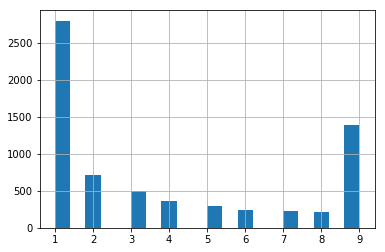

In [24]:
paired_df_grouped.n_best_co_occurence.hist(bins=20)

In [25]:
paired_df_grouped.n_best_co_occurence.describe()

count    6745.000000
mean        3.843884
std         3.220417
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max         9.000000
Name: n_best_co_occurence, dtype: float64

In [26]:
pd.set_option('display.max_colwidth', 100)

# Export

Let's export all file to github repo.
https://github.com/etalab/datasets_reco

In [27]:
# Dict of all co_occurences
datasets_co_occurence = paired_df_grouped[['dataset_1', 'best_co_occurence']].set_index('dataset_1').to_dict()['best_co_occurence']

We would like to show only co_occurence of top50 datasets in the following format :

`{dataset -> [(co_dataset, n_co_occurence), (..., ...)]}`


We first need to import it. 

**Note: Top 50 visited dataset is computed in `/most_visited_dataset.ipynd`. Run it if you want to refresh it!**

In [29]:
# Import top50 datasets
top50 = pd.read_csv('../top50visited.csv', sep=';')
# Remove URL form top50 (optional)
top50['dataset_slug'] = [x.split('www.data.gouv.fr/datasets/')[1] for x in top50.dataset]

top50['dataset_id'] = top50.dataset_slug.map(datasets_slug_id)

**Check if every slug has an id.**

If not, compute a [Levenshtein distance](https://fr.wikipedia.org/wiki/Distance_de_Levenshtein) to find the closest slug.

In [36]:
slug_without_id = top50[top50.dataset_id.isnull()]

if len(slug_without_id) > 0 :
    for slug in slug_without_id.dataset_slug:
        levenshtein_min_idx = datasets_ref.slug.apply(lambda x: editdistance.eval(x, slug)).idxmin()
        best_title = datasets_ref.ix[levenshtein_min_idx].title
        best_id = datasets_ref.ix[levenshtein_min_idx].id
        print("Best correspondance for slug \"%s\":\n-> %s (id: %s) " %
              (slug, best_title , best_id))
        # Fill missing id with the closest slug's id.
        top50.iloc[top50.dataset_slug == 'plan-cadastral-informatise-pci', 'dataset_id'] = best_id

In [37]:
assert top50.dataset_slug.isnull().sum() == 0

In [38]:
# Keep only top50 datasets in dict (and convert int to str)
co_occurence_on_top50 = {ds: [(el[0], str(el[1])) for el in datasets_co_occurence[ds]] for ds in top50.dataset_id.tolist()}

In [39]:
datasets_ref[datasets_ref.url.str.contains('informatise')]

,id,title,slug,url,organization,organization_id,description,frequency,license,temporal_coverage.start,...,last_modified,tags,metric.nb_uniq_visitors,metric.views,metric.followers,metric.reuses,metric.nb_visits,metric.discussions,metric.nb_hits,metric.issues
545,57750ee6c751df4db29901a0,Ilot cadastral (Plan cadastral informatisé du Grand Lyon),ilot-cadastral-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/ilot-cadastral-plan-cadastral-informatise-du-grand-lyon/,Métropole de Lyon,534fff7aa3a7292c64a77e0c,"Objet surfacique, correspondant à un ensemble de parcelles contiguës, à l&#x27;intérieur d&#x27;...",unknown,Licence Ouverte / Open Licence,NaN,...,2017-10-12T21:24:26.766000,"donnees-ouvertes,parcelles-cadastrales,passerelle-inspire,planning-cadastre",0,2,0,0,0,0,0,0
1730,57750ee6c751df568b9901a1,Parcelle historique (Plan cadastral informatisé du Grand Lyon),parcelle-historique-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/parcelle-historique-plan-cadastral-informatise-du-grand-lyon/,Métropole de Lyon,534fff7aa3a7292c64a77e0c,"Parcelle ne figurant plus au plan, par suite de mutation.\n\n__Origine__\n\nLes feuilles cadastr...",unknown,Licence Ouverte / Open Licence,NaN,...,2017-10-12T21:24:27.360000,"donnees-ouvertes,parcelles-cadastrales,passerelle-inspire,planning-cadastre",0,1,0,0,0,0,0,0
4508,5a0d95b0c751df2a6d7c4322,Subdivision fiscale (Plan cadastral informatisé du Grand Lyon),subdivision-fiscale-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/subdivision-fiscale-plan-cadastral-informatise-du-grand-lyon/,Métropole de Lyon,534fff7aa3a7292c64a77e0c,Partie d&#x27;une parcelle ayant une seule nature de culture ou de propriété et constituant une ...,unknown,Licence Ouverte / Open Licence,NaN,...,2017-11-16T14:42:08.363000,"france,parcelles-cadastrales,passerelle-inspire,planning-cadastre",0,0,0,0,0,0,0,0
4509,5a0d959ec751df2a6d7c431e,Détail surfacique (Plan cadastral informatisé du Grand Lyon),detail-surfacique-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/detail-surfacique-plan-cadastral-informatise-du-grand-lyon/,Métropole de Lyon,534fff7aa3a7292c64a77e0c,Détail topographique surfacique représenté par un signe conventionnel de type surfacique permett...,unknown,Licence Ouverte / Open Licence,NaN,...,2017-11-16T14:41:50.198000,"parcelles-cadastrales,passerelle-inspire,planning-cadastre",0,0,0,0,0,0,0,0
5238,5a0d959b88ee3831f0f0bd0d,Détail ponctuel (Plan cadastral informatisé du Grand Lyon),detail-ponctuel-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/detail-ponctuel-plan-cadastral-informatise-du-grand-lyon/,Métropole de Lyon,534fff7aa3a7292c64a77e0c,Détail topographique ponctuel représenté par un signe conventionnel de type ponctuel permettant ...,unknown,Licence Ouverte / Open Licence,NaN,...,2017-11-16T14:41:47.543000,"parcelles-cadastrales,passerelle-inspire,planning-cadastre",0,0,0,0,0,0,0,0
5322,5a0d959a88ee383353023b63,Borne limite de propriété (Plan cadastral informatisé du Grand Lyon),borne-limite-de-propriete-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/borne-limite-de-propriete-plan-cadastral-informatise-du-gra...,Métropole de Lyon,534fff7aa3a7292c64a77e0c,Borne située en limite de propriété et représentée par un symbole ponctuel.\n\n__Origine__\n\nLe...,unknown,Licence Ouverte / Open Licence,NaN,...,2017-11-16T14:41:46.329000,"parcelles-cadastrales,passerelle-inspire,planning-cadastre",0,0,0,0,0,0,0,0
5326,5a0d95b1c751df2aea761821,Bâtiment (Plan cadastral informatisé du Grand Lyon),batiment-plan-cadastral-informatise-du-grand-lyon,https://www.data.gouv.fr/fr/datasets/batiment-plan-cadastral-informatise-du-grand-lyon/,Métropole de Lyon,534fff7aa3a7292c64a77e0c,"Objet surfacique, correspondant à une construction assise sur une ou plusieurs parcelles cadastr...",unknown,Licence Ouverte / Open Licence,NaN,...,2017-11-16T14:42:09.4700

In [45]:
co_occurence_on_top50

{'53698f1aa3a729239d203653': [('58e53811c751df03df38f42d', '177'),
  ('536995aba3a729239d2047ad', '109')],
 '53698f4ca3a729239d2036df': [('53698f4da3a729239d2036ec', '92')],
 '53698f50a3a729239d2036f5': [('5710b9f088ee383cf54d8898', '45')],
 '53699027a3a729239d203920': [('5369a253a3a729239d2067fb', '113')],
 '536991b0a3a729239d203d13': [('53699233a3a729239d203e69', '166'),
  ('5726ef67c751df48e1fcca0d', '147'),
  ('536991b2a3a729239d203d1a', '125')],
 '536991b2a3a729239d203d1a': [('53699233a3a729239d203e69', '114')],
 '536991c5a3a729239d203d4b': [('545b55e1c751df52de9b6045', '398'),
  ('59591ca4a3a7291dcf9c8150', '259')],
 '53699233a3a729239d203e69': [('559c0341c751df4853390be6', '177'),
  ('536998c8a3a729239d205051', '162'),
  ('545b55e1c751df52de9b6045', '143')],
 '53699333a3a729239d204119': [('536998c8a3a729239d205051', '67'),
  ('54f32631c751df46a0882844', '58'),
  ('5862206588ee38254d3f4e5e', '58'),
  ('56ba2ce488ee382c284b6d5b', '56')],
 '536993f2a3a729239d204313': [('5862206588e

In [46]:
# Dump to json in datasets_reco repository.
# https://github.com/etalab/datasets_reco

for k, v in co_occurence_on_top50.items():
    ds_json = {k: v}
    filename = '../../datasets_reco/reco_json/{}.json'.format(k)
    with open(filename, 'w') as f:
        json.dump(ds_json, f)

### Wanna see slugs instead of ids ?

In [47]:
co_occurence_on_top50_slug = {datasets_id_slug.get(k): [(datasets_id_slug.get(el[0]), el[1]) for el in v] for k, v in co_occurence_on_top50.items()}

In [48]:
co_occurence_on_top50_slug

{'adresse-et-geolocalisation-des-etablissements-denseignement-du-premier-et-second-degres': [('base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret',
   '145')],
 'associations': [('repertoire-national-des-associations-rna', '277')],
 'associations-reconnues-d-utilite-publique': [('repertoire-national-des-associations-rna',
   '177'),
  ('fondations-reconnues-d-utilite-publique', '109')],
 'ban-base-adresse-nationale': [('base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret',
   '163')],
 'base-d-adresses-nationale-ouverte-bano': [('ban-base-adresse-nationale',
   '86'),
  ('base-officielle-des-codes-postaux', '61')],
 'base-de-donnees-accidents-corporels-de-la-circulation': [('base-de-donnees-des-accidents-corporels-de-la-circulation',
   '92')],
 'base-de-donnees-publique-des-medicaments-base-officielle': [('transparence-sante-1',
   '45')],
 'base-officielle-des-codes-postaux': [('geofla-r', '260'),
  ('correspondance-code-insee-code-postal', '224'),
  ('

## Build a graph.

Now it would be ideal to build a graph using networkX of all linked datasets form top50 (to begin with).

To do, so we'll first need to build 2 dicts :

1. A dict of correspondance : dsA -> [dsB, dsC, dsD]
2. A dict of weight : dsA -> [1, 4, 8]


In [49]:
full_weight_dict = {}
for key, value in co_occurence_on_top50_slug.items():
    for tup in value:
        full_weight_dict[key]={tup[0]: {'weight':tup[1]}}

In [50]:
co_occ_by_list = []
G2=nx.Graph()
for key, value in co_occurence_on_top50_slug.items():
    for tup in value:
        G2.add_edge(key, tup[0])
        G2[key][tup[0]]['weight']=tup[1]


In [53]:
nx.write_gexf(G2, '../datasets_graphs/graph2.gexf')

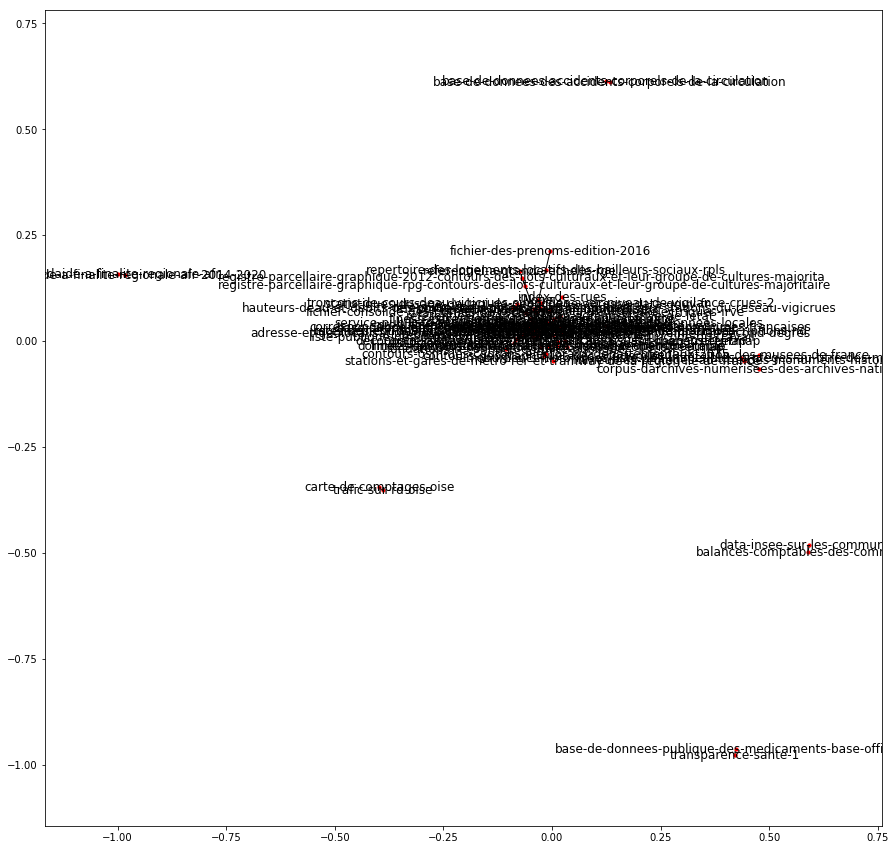

In [54]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G2, with_labels=True, node_size=10)